In [ ]:
# (c) Westerveld 2023
# Watermark remover training and development using pytorch library with python
# A convolutional variational autoencoder that takes in an image with a watermark and (ideally) outputs the same image but without a watermark
# The architecture compresses the image then upsamples it, removing the watermark in the process and outputting an image.
# uses CLWD dataset

In [ ]:
!gdown 17y1gkUhIV6rZJg1gMG-gzVMnH27fm4Ij

!pip install pyunpack
!pip install patool
from pyunpack import Archive
Archive("CLWD.rar").extractall("")

Downloading...
From: https://drive.google.com/uc?id=17y1gkUhIV6rZJg1gMG-gzVMnH27fm4Ij
To: /content/CLWD.rar
100% 3.35G/3.35G [00:43<00:00, 77.4MB/s]
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 3.9 MB/s eta 0:00:00


In [1]:
# include libraries
#!pip install torchvision
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader 
import torch.nn as nn
import torch.optim as optim
from torchvision.io import read_image
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torchvision.transforms as T

# check if gpu available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [6]:
# custom dataset - length 60 000, returns watermarked and watermark free image
class Coles(Dataset):
  def __init__(self, watermark_free, watermarked, transform = None, target_transform = None):
    #self.watermark_free = Image.open("CLWD/train/Watermark_image" + watermark_free)
    #self.img_dir = watermarked
    self.transform = transform
    self.target_transform = target_transform
  # C:\Users\Cole\Desktop/CLWD/
  def __getitem__(self, idx):
    img_path = r"C:\Users\Cole\Desktop/CLWD/CLWD/train/Watermarked_image/" + str(idx + 1) + ".jpg"
    watermarked = Image.open(img_path).convert('RGB')
    img_path = r"C:\Users\Cole\Desktop/CLWD/CLWD/train/Watermark_free_image/" + str(idx + 1) + ".jpg"
    watermark_free = Image.open(img_path).convert('RGB')
    

    transform_one = T.ToTensor() 
    img = torch.FloatTensor()
    label = torch.FloatTensor()
    #img.to(device)
    #label.to(device)
    img = transform_one(watermarked) 
    label = transform_one(watermark_free)

   
    # watermarked.cuda()
    # watermark_free.cuda()
    

    return img, label
  
  def __len__(self):
    #hardcoded for now
    return 60_000

Train_dataset = Coles("", "")

In [ ]:
# THIS WHOLE BLOCK IS NOT NEEDED

#this is all testing and messing around

# TODO: make function that opens image as pil image, crops it into many 32x32 images
# and converts them to PyTorch tensors. 
# returns a list of pytorch tensors
# for now if it can only take images that have lengths that are a multiples of 32 thats fine 

# Opens a image in RGB mode
# im = Image.open(r"CLWD/train/Watermarked_image/5.jpg")
 
# # Size of the image in pixels (size of original image)
# # (This is not mandatory)
# width, height = im.size
 
# # Setting the points for cropped image
# left = 0
# top = 0 
# right = 128
# bottom = 128
 
# # Cropped image of above dimension
# # (It will not change original image)
# im1 = im.crop((left, top, right, bottom))
 
# Display image - testting




watermarked = read_image(r"CLWD/train/Watermarked_image/1.jpg")
print(watermarked.shape)
# im1.show()

img = Image.open(r"CLWD/train/Watermarked_image/5.jpg")
#plt.imshow(img)
#plt.show()

# for now ill just rezize the images
transform = T.Resize(size = (100,100))
img = transform(img)

#plt.imshow(img)
#plt.show()

transform_two = T.Resize(size = (250,250))
img = transform_two(img)

#plt.imshow(img)
#plt.show()

torch.Size([3, 256, 256])


In [3]:
# Defining the model - encoder and decoder convolutional part 

class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    #takes in 64*64 (or as much as I reasonably can) by 3 channels
    self.encoder = nn.Sequential(
        nn.Conv2d(3, 64, 3, stride = 2, padding = 1),
        nn.ReLU(),
        nn.Conv2d(64, 128, 3, stride = 2, padding = 1),
        nn.ReLU(),
        nn.Conv2d(128, 256, 3, stride = 2, padding = 1),
        nn.ReLU(),
        nn.Conv2d(256, 512, 3, stride = 2, padding = 1),
        nn.ReLU(),
        nn.Conv2d(512, 1024, 7),

    )
        # this may not be perfect but this is how i think it is right now
        # conv2d(in_channels, out_channels, kernel size, stride, padding)
        # in channels is the number of channels that are input, for this case 3 because R, G, B
        # out channels is number of output(width of the matrix?), will be batch size - number of images
        # kernel size, area of sqare (or rectangle if tuple is provided) that is used to convolve pixel
        # kernel size will probably just be 3, meaning thagt if x is the convoluted pixel then it would take from pixels like this:
        # PPP
        # PxP
        # PPP
        # stride is how many pixels it skips, should probably just be 1
        # padding is how much it leaves off the edges, should be 1
        
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(1024, 512, 7),
        nn.ReLU(),
        nn.ConvTranspose2d(512, 256, 3, stride = 2, padding = 1, output_padding = 1),
        nn.ReLU(),
        nn.ConvTranspose2d(256, 128, 3, stride = 2, padding = 1, output_padding = 1),
        nn.ReLU(),
        nn.ConvTranspose2d(128, 64, 3, stride = 2, padding = 1, output_padding = 1),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 3, 3, stride = 2, padding = 1, output_padding = 1),
        nn.Sigmoid()

    )

  # output
  def forward(self, x):
    #print("began")
    encoded = self.encoder(x)
    #print(encoded)
    decoded = self.decoder(encoded)
    return decoded


In [4]:
# initializing the model 
model = Encoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-4)


In [ ]:
print("Hello World!")

#function to display image
def display(img_path):
  img = mpimg.imread(img_path)
  imgplot = plt.imshow(img)
  plt.show()
  return 0

display("CLWD/train/Watermarked_image/59999.jpg")



Hello World!


FileNotFoundError: ignored

In [8]:
# initializing model object and dataset for training

train_dataloader = DataLoader(Train_dataset, batch_size=16, shuffle=True)

#train_dataloader.to(device)



# move to gpu - im not gonna put this in yet until all other bugs are worked out 
# so as to not intrudce more until current ones are fixed
model.to(device)
criterion.to(device)


#transform = T.Resize(size = (256,256))
transform = T.ToPILImage()

# Training loop
epochs = 6
for e in range(epochs):
    counter = 0
    running_loss = 0
    for images, labels in train_dataloader:
        counter += 1
        if counter % 37.5 == 0:
          print("training at epoch ", e, " ", (counter / 3750) * 100, "% done")
        labels = labels.to(device)
        # print(images.shape)
        # images = images.reshape(-1, 256*256) * 0.00390625
        # print(images.shape)
        # print(images)
        # images = images.float()
        # print(images.shape)
        # print(images)
        #print("label shape", labels.shape)
        #print("label type", type(labels))

        #print(len(images))
        #batch_size, channels, depth, height, width
        
        #images = np.reshape(images, (len(images), 3, 256, 256)) /256
        
        images = images.to(device)
        #images = torch.cat([images[0:-1], images[-1+1:]])
        
        
        #images = np.reshape(images, (len(images), 3, 256, 256)) /256
        
        #print(images.shape)
        #images = images.float()
        #print(images)
        #print("image shape", images.shape)
        
        # Training pass
        
        #print("image type:", type(images))

        #transform = T.ToPILImage()
        
        #img = labels[0]
        #pic1 = transform(img)
        #pic1.show()
        
        output = model(images)

        output.to(device)
        
        optimizer.zero_grad()

        #print("output cuda: ", output.is_cuda)
        #print("labels cuda: ", labels.is_cuda)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    torch.save({
            'epoch': e,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, f"Take_four_epoch-{e}.pth")

training at epoch  0   2.0 % done
training at epoch  0   4.0 % done
training at epoch  0   6.0 % done
training at epoch  0   8.0 % done
training at epoch  0   10.0 % done
training at epoch  0   12.0 % done
training at epoch  0   14.000000000000002 % done
training at epoch  0   16.0 % done
training at epoch  0   18.0 % done
training at epoch  0   20.0 % done
training at epoch  0   22.0 % done
training at epoch  0   24.0 % done
training at epoch  0   26.0 % done
training at epoch  0   28.000000000000004 % done
training at epoch  0   30.0 % done
training at epoch  0   32.0 % done
training at epoch  0   34.0 % done
training at epoch  0   36.0 % done
training at epoch  0   38.0 % done
training at epoch  0   40.0 % done
training at epoch  0   42.0 % done
training at epoch  0   44.0 % done
training at epoch  0   46.0 % done
training at epoch  0   48.0 % done
training at epoch  0   50.0 % done
training at epoch  0   52.0 % done
training at epoch  0   54.0 % done
training at epoch  0   56.00000

In [ ]:
# test model

In [ ]:
#GET DATASET X and Y Labels, need to do on home computer as chromebook does not have enough storage

#Convert X and Y to tensors so that NN can use


# #Defining The Model
# model = nn.Sequential
# (
#     #This is too much... ran out of RAM
#     #how many nodes in hidden layers? Thought this was good but its too much...
#     #inputs all pixels of 256x256 image 
 
#     # need to take 32*32 image segments
#     # meaning 1024 inputs
#     # order 1024, 512, 256, 128, 64 then back up for nodes and convolutions
#     # from https://openaccess.thecvf.com/content/WACV2021/papers/Liu_WDNet_Watermark-Decomposition_Network_for_Visible_Watermark_Removal_WACV_2021_paper.pdf
#     # page 4: use layers 2^(5+i) up then down
#     nn.Linear(1024, 512),
#     nn.ReLU(),
 
#     #Hidden Layers
#     nn.Linear(512, 256),
#     nn.ReLU(),
#     nn.Linear(256, 512),
#     nn.ReLU(),
#     nn.Linear(256, 128),
#     nn.ReLU(),
#     nn.Linear(128, 64),
#     nn.ReLU(),
#     nn.Linear(64, 128),
#     nn.ReLU(),
#     nn.Linear(128, 256),
#     nn.ReLU(),
#     nn.Linear(256, 512),
#     nn.ReLU(),


#     #Output Layer
#     nn.Linear(512, 1024),
#     nn.ReLU()
# )
# print(model)



Feature batch shape: torch.Size([16, 3, 256, 256])
Labels batch shape: torch.Size([16, 3, 256, 256])


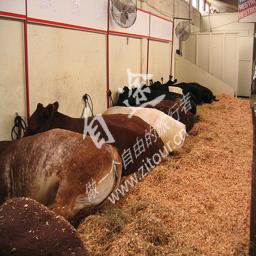

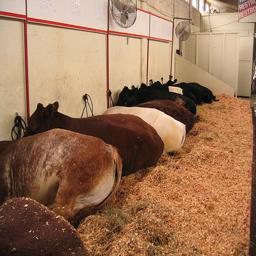

In [ ]:
# Display image and label.
Coles_Data = Coles("", "")
train_dataloader = DataLoader(Coles_Data, batch_size=16, shuffle=True)


train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0]#.squeeze()
label = train_labels[0]

transform = T.ToPILImage()
pic1 = transform(img)
pic1.show()

label = train_features[0]#.squeeze()
label = train_labels[0]
pic2 = transform(label)
pic2.show()

#print(f"Label: {label}")